In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 200M/200M [00:01<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fahadullaha/facial-emotion-recognition-dataset/versions/1


In [3]:
!pip install kaggle tensorflow keras opencv-python numpy matplotlib

In [4]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow

In [5]:
os.environ['KAGGLE_USERNAME'] = "harini2812"   # <-- Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = "b3b1321e8e9f4db06e1f5b965a153698"

In [6]:
!kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 68% 137M/200M [00:00<00:00, 1.43GB/s]
100% 200M/200M [00:00<00:00, 941MB/s] 


In [20]:
!ls FER

processed_data


In [21]:
with zipfile.ZipFile("facial-emotion-recognition-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("FER")

In [22]:
train_dir = "FER/processed_data"
test_dir = "FER/processed_data"

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
!ls $train_dir

angry  disgust	fear  happy  neutral  sad  surprise


In [25]:
!ls FER/processed_data

angry  disgust	fear  happy  neutral  sad  surprise


In [26]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'
)

Found 49779 images belonging to 7 classes.


In [27]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'
)

Found 49779 images belonging to 7 classes.


In [28]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 259s 330ms/step - accuracy: 0.2568 - loss: 1.8622 - val_accuracy: 0.4550 - val_loss: 1.4751
Epoch 2/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 256s 329ms/step - accuracy: 0.4056 - loss: 1.5796 - val_accuracy: 0.4993 - val_loss: 1.3283
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 254s 327ms/step - accuracy: 0.4657 - loss: 1.4361 - val_accuracy: 0.5169 - val_loss: 1.2878
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 278s 357ms/step - accuracy: 0.4857 - loss: 1.3794 - val_accuracy: 0.5615 - val_loss: 1.1863
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 253s 325ms/step - accuracy: 0.5085 - loss: 1.3171 - val_accuracy: 0.5695 - val_loss: 1.1351
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 253s 325ms/step - accuracy: 0.5216 - loss: 1.2901 - val_accuracy: 0.5781 - val_loss: 1.1278
Epoch 7/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 253s 325ms/step - accuracy: 0.5278 - loss: 1.2612 - val_accuracy: 0.5949 - val_loss: 1.0747
Epoch 8/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 253s 326ms/step - accuracy: 0.5368 -

In [31]:
model.save("emotion_model.h5")

In [32]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [33]:
from tensorflow.keras.models import load_model
model = load_model("emotion_model.h5")

In [34]:
emotion_labels = list(train_generator.class_indices.keys())

In [35]:
def predict_emotion(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48,48))
        roi = roi.astype("float") / 255.0
        roi = np.expand_dims(roi, axis=0)
        roi = np.expand_dims(roi, axis=-1)
        preds = model.predict(roi)[0]
        label = emotion_labels[np.argmax(preds)]
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    cv2_imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


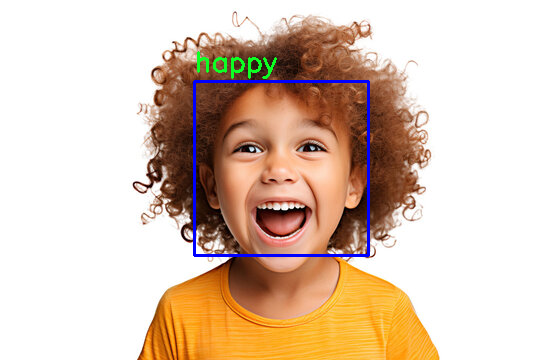

In [36]:
predict_emotion("/content/happy.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


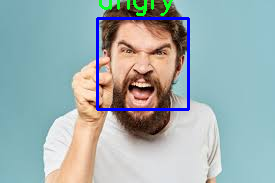

In [41]:
predict_emotion("/content/angry.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


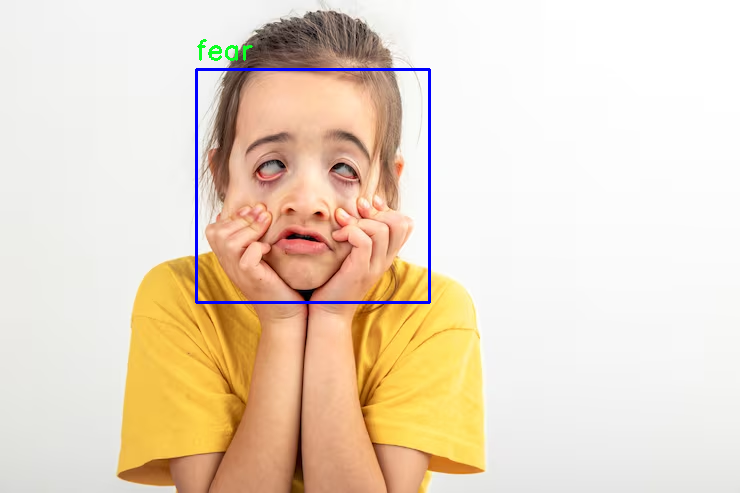

In [45]:
predict_emotion("/content/fear.jpg")